In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EEMD
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [2]:
# 1. Data loading and preprocessing
def load_and_preprocess_data(data_path, file_name, target_column):
    df = pd.read_csv(f"{data_path}/{file_name}")
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)
    data = df[[target_column]].values
    return data, df

def split_data(data, train_size=0.7, val_size=0.15):
    train_idx = int(len(data) * train_size)
    val_idx = int(len(data) * (train_size + val_size))
    
    train_data = data[:train_idx]
    val_data = data[train_idx:val_idx]
    test_data = data[val_idx:]
    
    return train_data, val_data, test_data

def scale_data(train_data, val_data, test_data):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, val_scaled, test_scaled, scaler

# 2. EEMD Decomposition
def decompose_series_with_eemd(data, num_imfs=10):
    eemd = EEMD()
    imfs = eemd.eemd(data.flatten())
    return imfs

def plot_imfs(imfs, original_data):
    plt.figure(figsize=(12, 8))
    plt.subplot(len(imfs)+1, 1, 1)
    plt.plot(original_data, label="Original Data")
    plt.legend()

    for i, imf in enumerate(imfs):
        plt.subplot(len(imfs)+1, 1, i+2)
        plt.plot(imf, label=f'IMF {i+1}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# 3. LSTM Model Definition
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def prepare_data_for_lstm(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def train_lstm_model(X_train, y_train, X_val, y_val, n_epochs=50):
    model = create_lstm_model((X_train.shape[1], 1))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=2)
    return model, history

def plot_training_history(history):
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

# 4. Prediction and Visualization
def predict_and_evaluate(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    print(f'Test MSE: {mse}')
    
    plt.plot(y_test_rescaled, label='True Data')
    plt.plot(predictions_rescaled, label='Predictions')
    plt.legend()
    plt.title('Predictions vs True Data')
    plt.show()

    return predictions_rescaled, mse

# 5. Full procedure
def run_eemd_lstm_pipeline(data_path, file_name, target_column, n_steps=30, n_epochs=50):
    # Load and preprocess the data
    data, df = load_and_preprocess_data(data_path, file_name, target_column)
    train_data, val_data, test_data = split_data(data)
    
    # Scale the data
    train_scaled, val_scaled, test_scaled, scaler = scale_data(train_data, val_data, test_data)
    
    # EEMD decomposition
    imfs = decompose_series_with_eemd(data)
    plot_imfs(imfs, data)
    
    # Prepare data for LSTM (using only high-frequency IMFs)
    high_freq_imfs = np.sum(imfs[:10], axis=0).reshape(-1, 1)
    X_train, y_train = prepare_data_for_lstm(train_scaled, n_steps)
    X_val, y_val = prepare_data_for_lstm(val_scaled, n_steps)
    X_test, y_test = prepare_data_for_lstm(test_scaled, n_steps)
    
    # Train LSTM
    model, history = train_lstm_model(X_train, y_train, X_val, y_val, n_epochs)
    plot_training_history(history)
    
    # Predict and evaluate
    predictions, mse = predict_and_evaluate(model, X_test, y_test, scaler)
    
    return model, predictions, mse

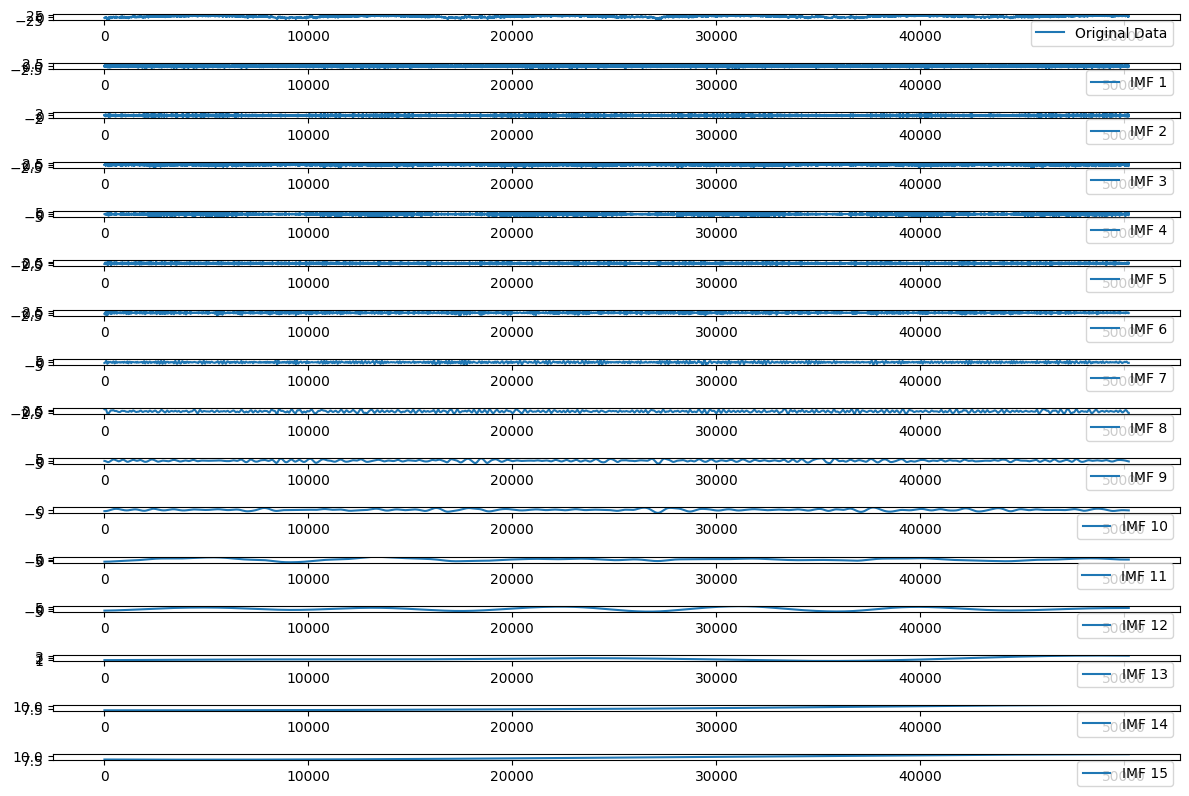

Epoch 1/20


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


549/549 - 14s - 26ms/step - loss: 0.0044 - val_loss: 6.4849e-04
Epoch 2/20
549/549 - 11s - 19ms/step - loss: 7.1826e-04 - val_loss: 5.9724e-04
Epoch 3/20
549/549 - 10s - 19ms/step - loss: 4.7159e-04 - val_loss: 2.7166e-04
Epoch 4/20
549/549 - 11s - 21ms/step - loss: 3.1389e-04 - val_loss: 1.9817e-04
Epoch 5/20
549/549 - 13s - 24ms/step - loss: 2.4851e-04 - val_loss: 1.6652e-04
Epoch 6/20
549/549 - 12s - 22ms/step - loss: 2.1971e-04 - val_loss: 2.8003e-04
Epoch 7/20
549/549 - 11s - 20ms/step - loss: 2.0351e-04 - val_loss: 1.5422e-04
Epoch 8/20
549/549 - 13s - 24ms/step - loss: 1.9852e-04 - val_loss: 1.5794e-04
Epoch 9/20
549/549 - 13s - 23ms/step - loss: 1.9090e-04 - val_loss: 1.8970e-04
Epoch 10/20
549/549 - 11s - 21ms/step - loss: 1.9008e-04 - val_loss: 2.3563e-04
Epoch 11/20
549/549 - 13s - 23ms/step - loss: 1.9003e-04 - val_loss: 1.4289e-04
Epoch 12/20
549/549 - 12s - 22ms/step - loss: 1.8290e-04 - val_loss: 1.4646e-04
Epoch 13/20
549/549 - 14s - 25ms/step - loss: 1.8416e-04 - val_l

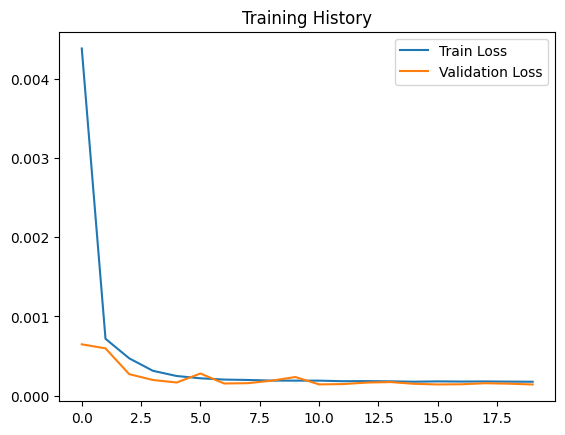

235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Test MSE: 0.5714588580298613


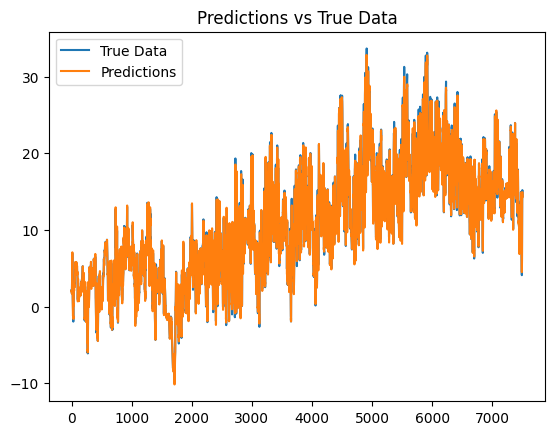

In [3]:
# Run the pipeline
data_path = './../data/'
file_name = 'weather_dataset_preprocesado.csv'
target_column = 'T (degC)'

model, predictions, mse = run_eemd_lstm_pipeline(data_path, file_name, target_column, n_epochs=20)